## Plots - Simulations
In this notebook, we take outputs from our simulations run and make a series of plots for the 
THOR paper. 

[Survey Footprint [Fig 5]](#Survey-Footprint)  
[Create and Propagate a Test Orbit [Fig 1]](#Create-and-Propagate-a-Test-Orbit)  
[Heliocentric Transformation and Projection [Fig 2]](#Heliocentric-Transformation-and-Projection)  
[Hough Transform [Fig 3]](#Hough-Transform)  
[Co-rotating Frame Velocities [Fig 4]](#Co-rotating-Frame-Velocities)  
[Completeness [Fig 7]](#Completeness)   
[Non-linear Velocities](#Non-linear-Velocities)  
[Cluster Summary](#Cluster-Summary)

This notebook creates Figures 1 - 5, 7.

Data and results files for this notebook may be downloaded [here](https://dirac.astro.washington.edu/~moeyensj/projects/thor/paper1/).

In [44]:
import glob
import os
import copy
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
sns.set(font_scale=1.0, context="paper", style="ticks")
sns.set_palette("viridis")

from astropy.time import Time

from scipy.stats import binned_statistic_2d

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

In [2]:
import thor

from thor import __version__
print("THOR version: {}".format(__version__))

import difi

from difi import __version__
print("difi version: {}".format(__version__))

THOR version: 1.1.dev199+g1c54766.d20210401
difi version: 1.1.dev57+gf3bff13.d20210323


In [3]:
DPI = 300
SAVE_DIR = "plots/"
FORMAT = "jpg"

SAVE_FIGS = True

In [4]:
DATABASE = "/home/moeyensj/projects/thor/thor_data/msst_4x4/msst_survey.db"
con = sql.connect(DATABASE)

In [5]:
observations_noNoise = pd.read_sql("""SELECT * FROM observations WHERE night < 59754""", con)
print(len(observations_noNoise))
observations_noNoise.drop_duplicates(subset=["designation", "exp_mjd"], inplace=True)
print(len(observations_noNoise))
noise = pd.read_sql("""SELECT * FROM noise_100 WHERE night < 59754""", con)
noise["obsId"] = np.arange(observations_noNoise["obsId"].values[-1] + 1, observations_noNoise["obsId"].values[-1] + 1 + len(noise))

2315689
2313850


In [6]:
observations = pd.concat([observations_noNoise, noise], sort=False)
observations.reset_index(inplace=True, drop=True)
observations["obsId"] = observations["obsId"].astype(str)
del observations_noNoise
del noise

In [7]:
survey = pd.read_sql("""SELECT * FROM survey""", con)

In [8]:
orbits = pd.read_sql("""SELECT * FROM mpcOrbitCat""", con)
# Only grab the orbits of objects with observations
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset=["designation"], inplace=True)
con.close()

In [9]:
from thor.orbits import Orbits

RUN_DIR = "/mnt/data/projects/thor/thor_results/msst_4x4/v1.1/run_4/"
ANALYSIS_DIR = os.path.join(RUN_DIR, "analysis")

preprocessed_observations = pd.read_csv(
    "/mnt/data/projects/thor/thor_data/msst_4x4/preprocessed_observations.csv",
    index_col=False,
    dtype={"obs_id" : str}
)
preprocessed_associations = pd.read_csv(
    "/mnt/data/projects/thor/thor_data/msst_4x4/preprocessed_associations.csv",
    index_col=False,
    dtype={"obs_id" : str}
)
analysis_observations = preprocessed_observations.merge(preprocessed_associations, on="obs_id")

test_orbits = Orbits.from_csv(os.path.join(RUN_DIR, "test_orbits_in.csv"))
test_orbits = test_orbits.to_df(include_units=False)

all_orbits_recovered = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "all_orbits_recovered.csv"),
    index_col=False
)
all_truths_recovered = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "all_truths_recovered.csv"),
    index_col=False
)
summary_recovered = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "summary_recovered.csv"),
    index_col=False
)
all_linkages = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "all_linkages.csv"),
    index_col=False
)
all_truths = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "all_truths.csv"),
    index_col=False
)
summary = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "summary.csv"),
    index_col=False
)
summary_components = pd.read_csv(
    os.path.join(ANALYSIS_DIR, "summary_components.csv"),
    index_col=False
)

In [10]:
test_orbits_ = observations[observations["designation"].isin(test_orbits["orbit_id"].values)].drop_duplicates(subset=["designation"])
test_orbits = test_orbits.merge(test_orbits_, right_on="designation", left_on='orbit_id')

In [11]:
test_orbits

orbit_id         epoch          x         y         z        vx        vy  \
0    n0358  59740.248023  -1.822403 -0.861798 -0.010464  0.005203 -0.009630   
1  K10T54J  59740.247329  -2.335982 -0.790806  0.029560  0.001472 -0.008939   
2  K17H05D  59740.238995  -1.960220 -0.821299 -0.072469  0.003461 -0.009784   
3    79151  59740.238301  -2.045316 -0.862221 -0.148130  0.002745 -0.011507   
4    T8186  59740.220940  -2.981904 -0.590010 -0.220128  0.001167 -0.009082   
5    18043  59740.218856  -3.123217 -0.291872  0.158942  0.001035 -0.009255   
6  K14WS3Y  59740.247329  -3.410219 -0.757158  0.196942  0.001374 -0.008503   
7  K10O54W  59740.240384  -4.795452 -0.347436  0.343767  0.000900 -0.006856   
8  K14Wo9A  59740.218856 -42.021666  8.884724  1.669747 -0.000675 -0.002570   

         vz   obsId  visitId  ...  HEclObj_Z_au  HEclObj_dX/dt_au_p_day  \
0 -0.004288  146424      447  ...     -0.010464                0.005203   
1  0.001756  145167      446  ...      0.029560                0.001472   
2  0.003993  137603      434  ...     -0.072469                0.003461   
3  0.000024  135701      433  ...     -0.148130                0.002745   
4  0.000384  133036      408  ...     -0.220128                0.001167   
5  0.000171  128694      405  ...      0.158942                0.001035   
6  0.000890  145414      446  ...      0.196942                0.001374   
7 -0.000111  140019      436  ...      0.343767                0.000900   
8  0.000098  129889      405  ...      1.669747               -0.000675   

   HEclObj_dY/dt_au_p_day  HEclObj_dZ/dt_au_p_day  HEclObsy_X_au  \
0               -0.009630               -0.004288      -0.192642   
1               -0.008939                0.001756      -0.192653   
2               -0.009784                0.003993      -0.192794   
3               -0.011507                0.000024      -0.192805   
4               -0.009082                0.000384      -0.193098   
5               -0.009255                0.000171      -0.193133   
6               -0.008503                0.000890      -0.192653   
7               -0.006856               -0.000111      -0.192770   
8               -0.002570                0.000098      -0.193133   

  HEclObsy_Y_au HEclObsy_Z_au     EccAnom    TrueAnom  PosAngle_deg  
0     -0.996781      0.000045  219.303433  216.631113    143.419738  
1     -0.996779      0.000045  151.920698  159.848842    100.910241  
2     -0.996752      0.000045  160.063075  162.263771     83.138703  
3     -0.996749      0.000045   72.316952   81.977169    106.578372  
4     -0.996691      0.000045  154.771316  158.203162    102.339551  
5     -0.996684      0.000045  192.275299  191.324789    116.462626  
6     -0.996779      0.000045  150.836544  154.279498    113.620130  
7     -0.996756      0.000045  194.650708  191.634821    125.509645  
8     -0.996684      0.000045   61.456318   64.343425    122.978643  

[9 rows x 55 columns]

#### Survey Footprint

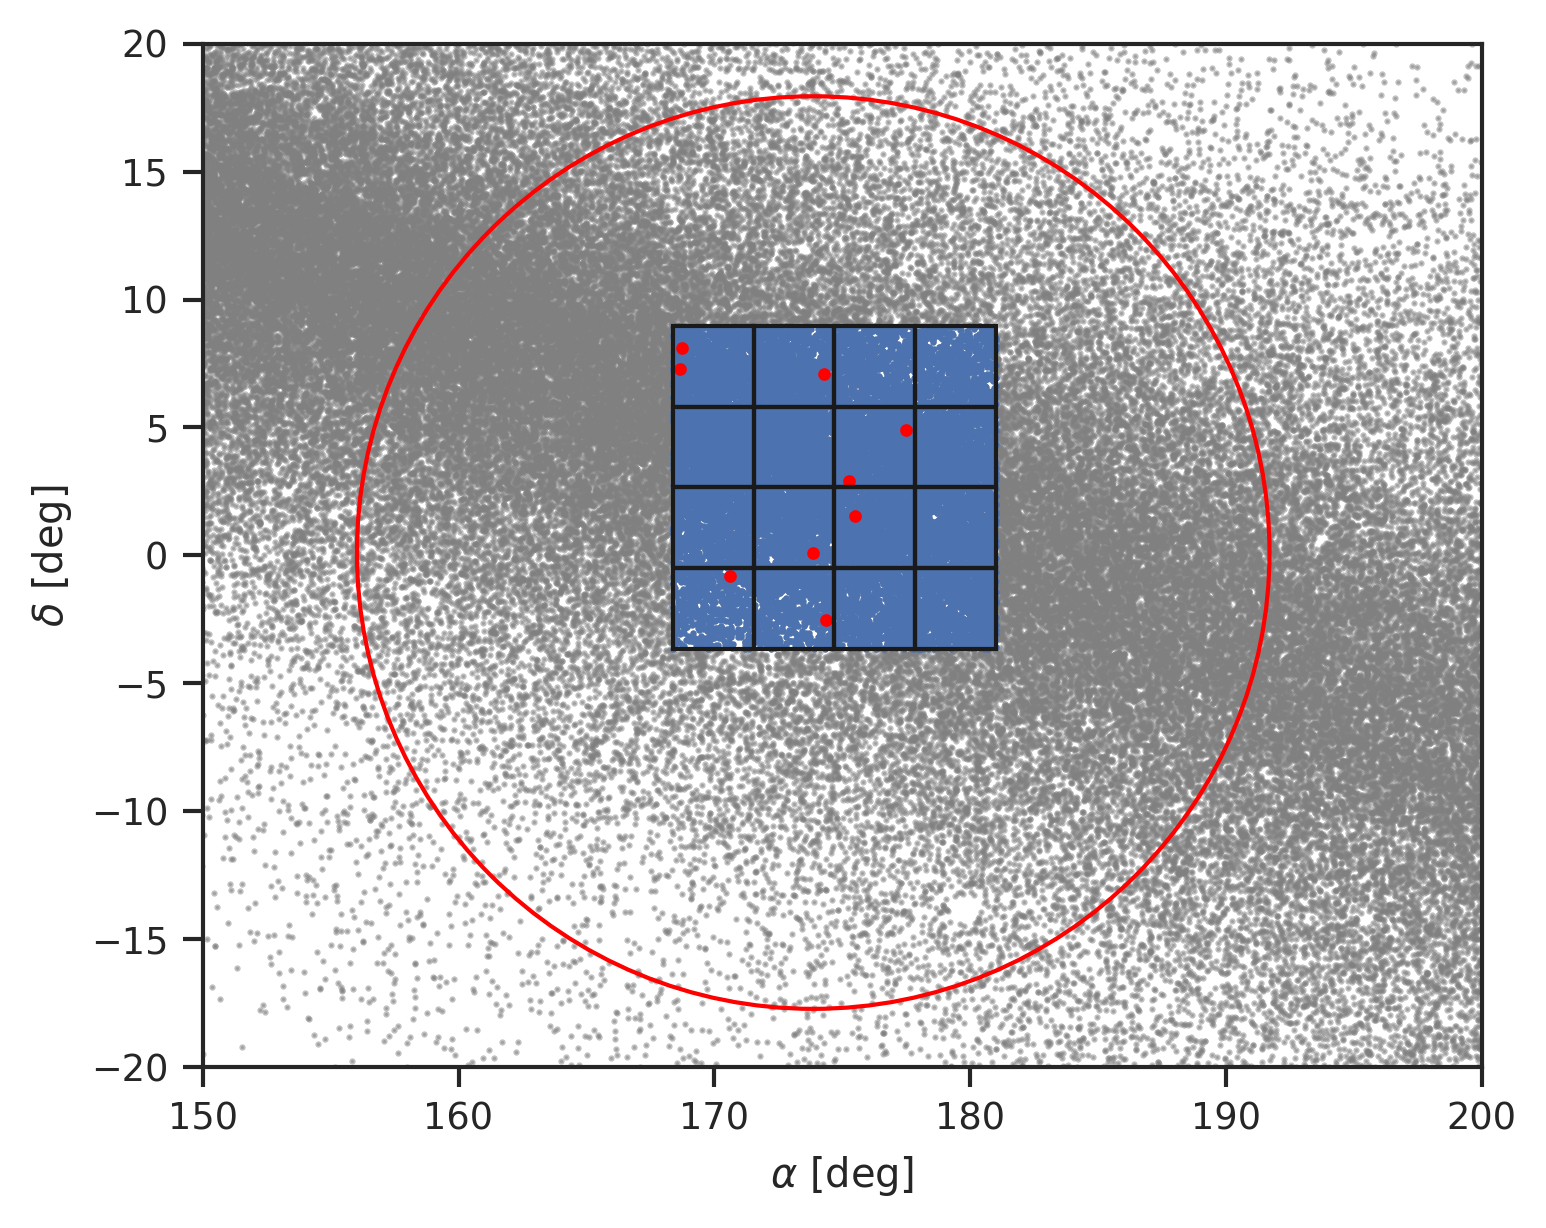

In [12]:
# Plot footprint
fieldArea = 10
xField = np.sqrt(fieldArea)
yField = np.sqrt(fieldArea)

fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))
ax.set_xlabel(r"$\alpha$ [$\deg$]")
ax.set_ylabel(r"$\delta$ [$\deg$]")
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
for xx, yy in zip(survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldRA_deg"].values, 
                  survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldDec_deg"].values):
    ax.add_patch(patches.Rectangle((xx-xField/2, yy-yField/2), xField, yField, fill=False, lw=1, color="k"))
ax.scatter(
    observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["RA_deg"].values, 
    observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["Dec_deg"].values,
    s=0.5,
    c="#808080",
    alpha=0.5
)
ax.scatter(
    observations[
        (observations["night"] == survey["night"].min()) 
        & (observations["designation"] != "NS")
        & (observations["fieldId"].isin(fields))]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) 
                        & (observations["designation"] != "NS")
                        & (observations["fieldId"].isin(fields))]["Dec_deg"].values,
           s=0.5,
           c="b")
ax.scatter(
    test_orbits["RA_deg"].values,
    test_orbits["Dec_deg"].values,
    s=5,
    c="red"
)
for ra, dec in test_orbits[test_orbits["orbit_id"].isin(["K17H05D"])][["RA_deg", "Dec_deg"]].values:
    ax.add_patch(patches.Circle([ra, dec], np.sqrt(1000/np.pi), fill=False, lw=1, color="red"))

ax.set_aspect("equal")
ax.set_ylim(-20, 20)
ax.set_xlim(150, 200)
if SAVE_FIGS == True:
    fig.savefig(os.path.join(SAVE_DIR, "simulations_footprint.{}".format(FORMAT)),
            bbox_inches='tight')

In [13]:
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
observations = observations[observations["fieldId"].isin(fields)]

In [14]:
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())].copy()
orbits.drop_duplicates(subset=["designation"], inplace=True)

### Create and Propagate a Test Orbit 

In [15]:
from thor import findAverageOrbits

average_object = findAverageOrbits(observations, orbits, d_values=[2.9, 3])
average_object["night"] = observations["night"].unique()

In [16]:
average_object

orbit_id       exp_mjd  HEclObj_X_au  HEclObj_Y_au  HEclObj_Z_au  \
0         1  59740.238889     -3.181559     -0.588165      0.111699   
1         1  59742.238889     -3.177792     -0.605928      0.110257   
2         1  59744.238889     -3.173913     -0.623669      0.108811   
3         1  59746.238889     -3.169924     -0.641388      0.107362   
4         1  59748.246528     -3.165808     -0.659153      0.105903   
5         1  59750.246528     -3.161597     -0.676827      0.104446   
6         1  59752.246528     -3.157276     -0.694477      0.102985   

   HEclObj_dX/dt_au_p_day  HEclObj_dY/dt_au_p_day  HEclObj_dZ/dt_au_p_day  \
0                0.001856               -0.008887               -0.000720   
1                0.001912               -0.008877               -0.000722   
2                0.001967               -0.008866               -0.000724   
3                0.002022               -0.008855               -0.000726   
4                0.002078               -0.008843               -0.000728   
5                0.002133               -0.008832               -0.000729   
6                0.002189               -0.008820               -0.000731   

       RA_deg   Dec_deg      r_au      a_au    i_deg        e designation  \
0  173.690623  5.035741  3.237396  2.963106  4.90315  0.09605       97142   
1  173.942092  4.877238  3.236922  2.963106  4.90315  0.09605       97142   
2  174.207906  4.713315  3.236437  2.963106  4.90315  0.09605       97142   
3  174.487654  4.544137  3.235942  2.963106  4.90315  0.09605       97142   
4  174.782119  4.369173  3.235435  2.963106  4.90315  0.09605       97142   
5  175.088703  4.189889  3.234919  2.963106  4.90315  0.09605       97142   
6  175.408183  4.005748  3.234393  2.963106  4.90315  0.09605       97142   

   night  
0  59740  
1  59742  
2  59744  
3  59746  
4  59748  
5  59750  
6  59752

In [17]:
no_noise = (~observations["designation"].isin(["NS"]))

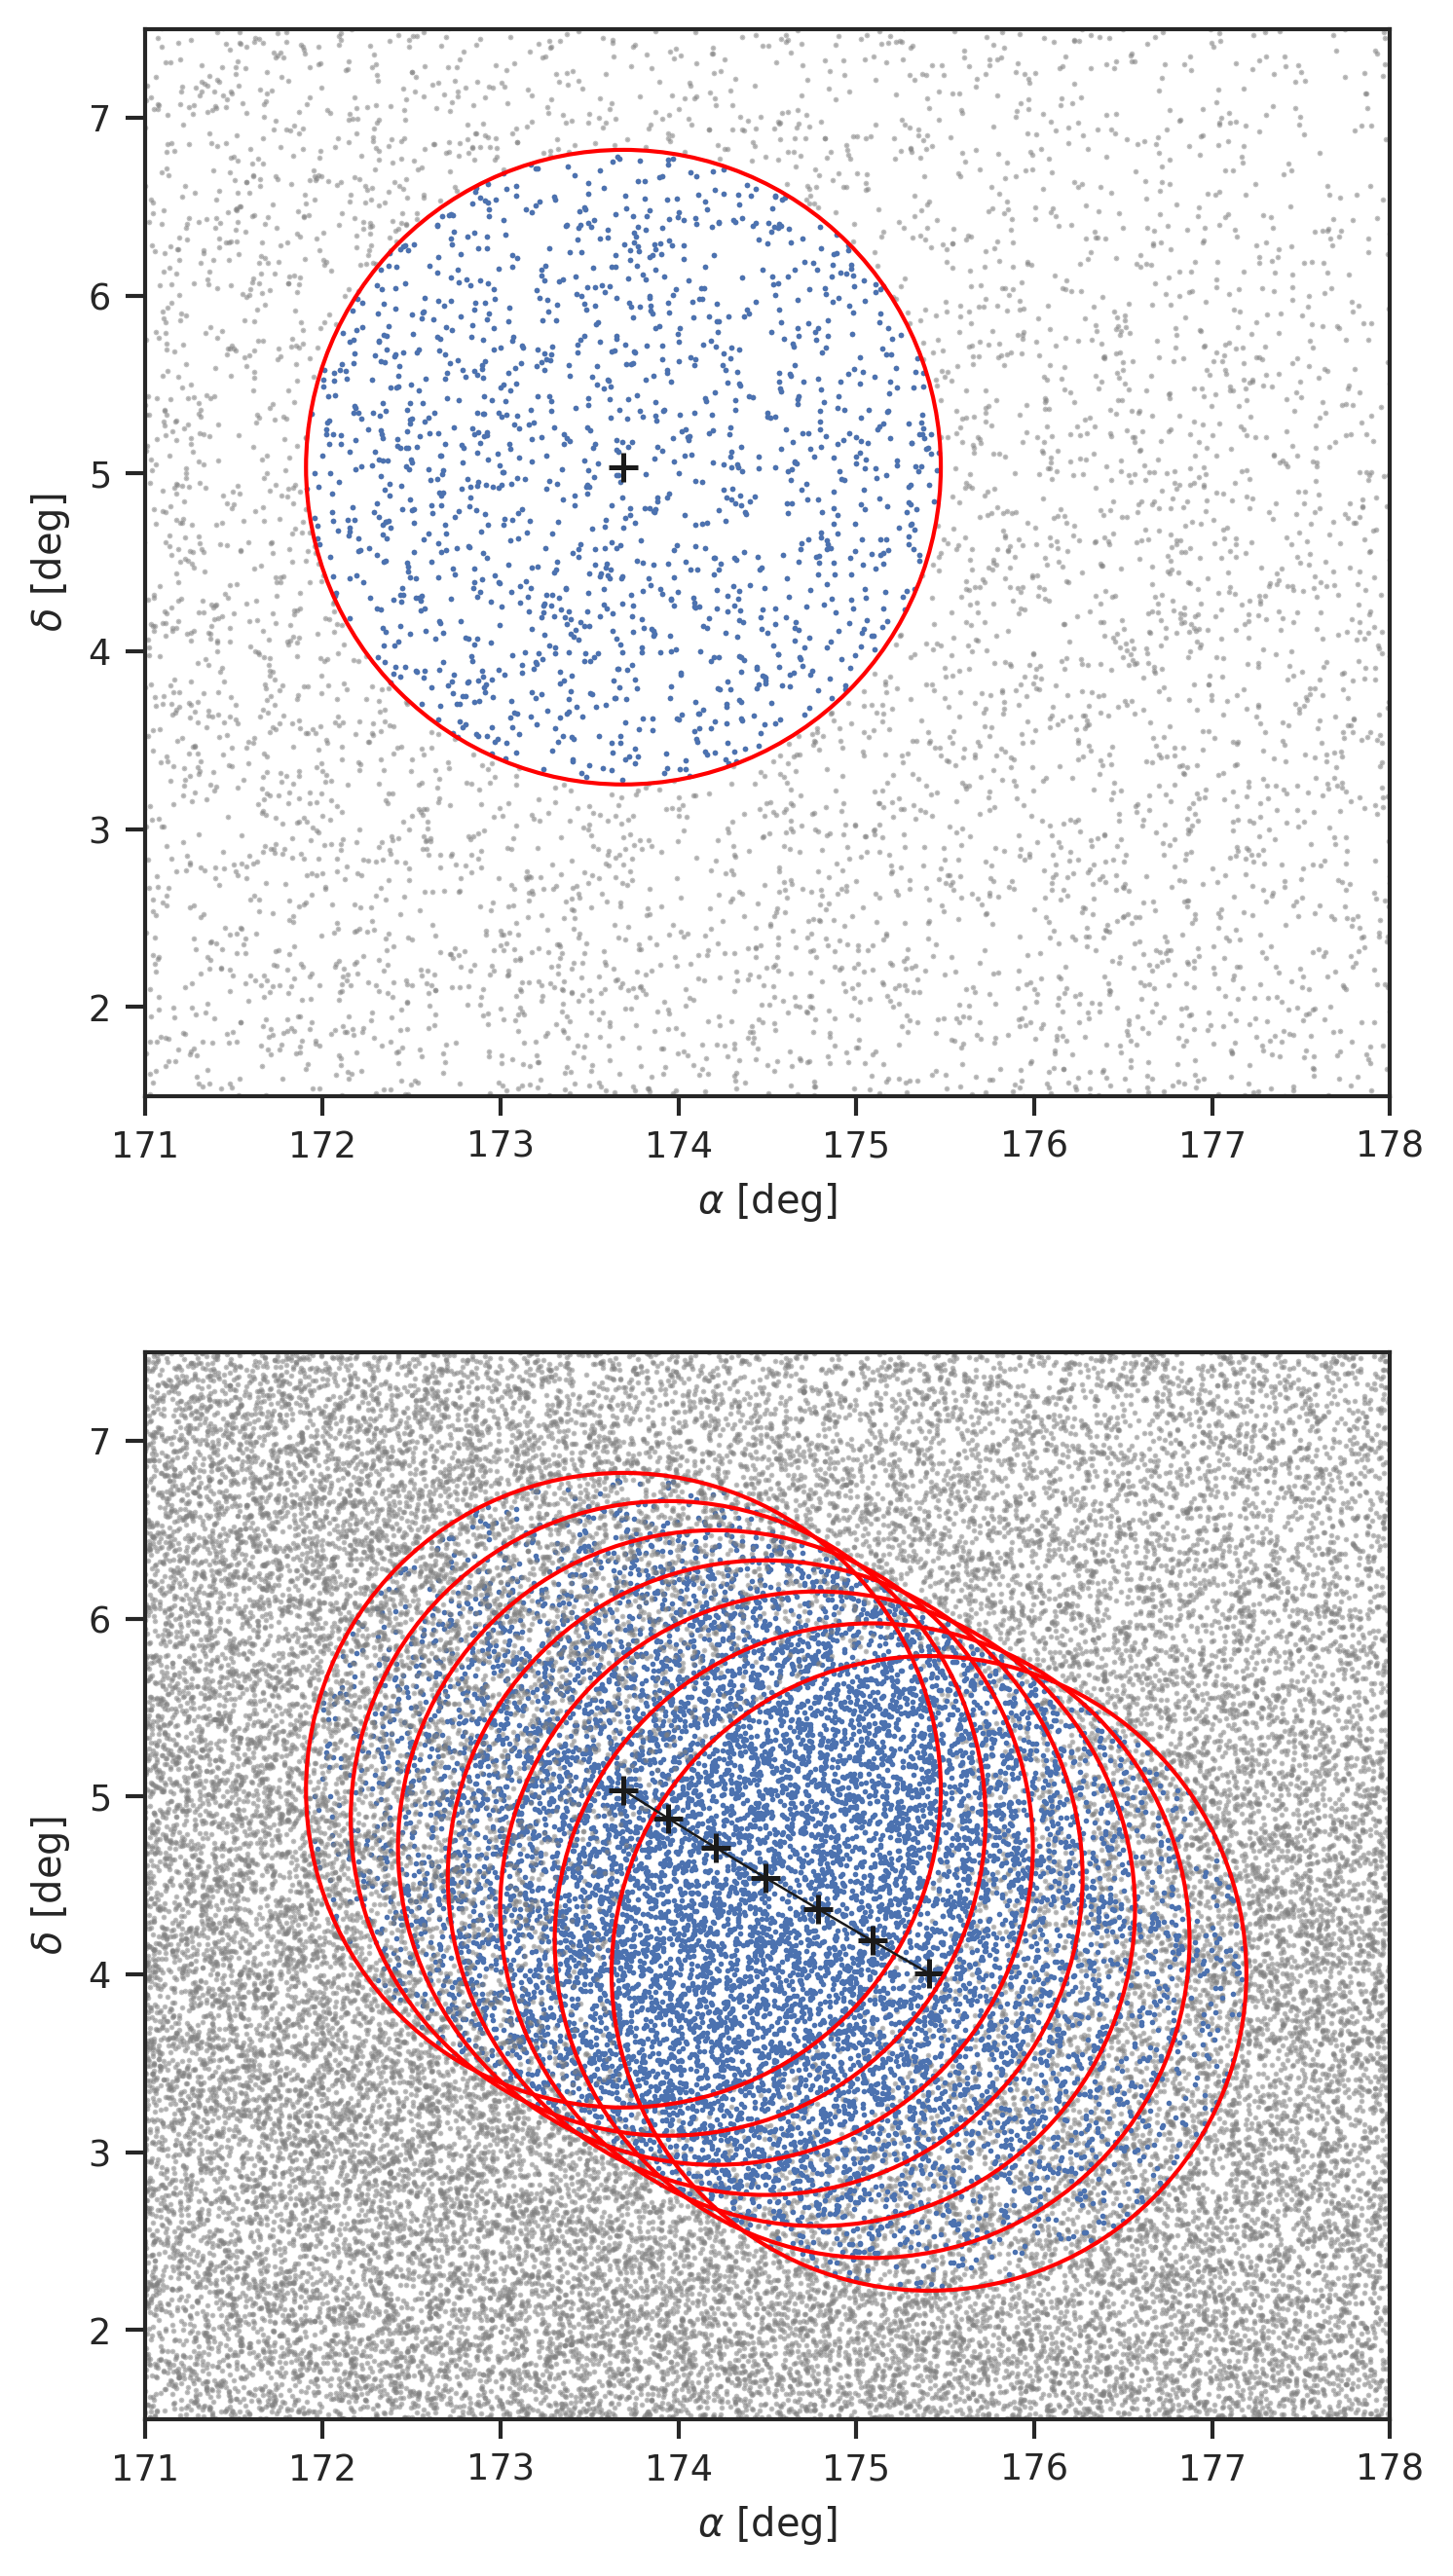

In [18]:
fig, ax = plt.subplots(2, 1, dpi=DPI, figsize=(5.5, 11))
ax[0].scatter(
    *observations[no_noise & (observations["night"] == 59740)][["RA_deg", "Dec_deg"]].values.T, 
    s=0.3, 
    c="#808080",
    alpha=0.5
)
ax[0].set_xlabel(r"$\alpha$ [$\deg$]")
ax[0].set_ylabel(r"$\delta$ [$\deg$]")
for ra, dec, night in average_object[["RA_deg", "Dec_deg", "night"]].values[0:1]:
    ax[0].add_patch(
        patches.Circle(
            [ra, dec], 
            np.sqrt(10/np.pi), 
            fill=False, 
            lw=1, 
            color="red"
        )
    )
    ax[0].scatter(
        *observations[(np.sqrt((observations["RA_deg"] - ra)**2 + (observations["Dec_deg"] - dec)**2) <= np.sqrt(10/np.pi))
            & no_noise
            & (observations["night"] == night)][["RA_deg", "Dec_deg"]].values.T, 
        s=0.3, 
        c="b"
    )
ax[0].scatter(*average_object[["RA_deg", "Dec_deg"]].values[0], 
              s=50,
              c="k", 
              marker="+")

ax[1].set_xlabel(r"$\alpha$ [$\deg$]")
ax[1].set_ylabel(r"$\delta$ [$\deg$]")

for ra, dec, night in average_object[["RA_deg", "Dec_deg", "night"]].values:
    ax[1].scatter(*observations[(np.sqrt((observations["RA_deg"] - ra)**2 + (observations["Dec_deg"] - dec)**2) > np.sqrt(10/np.pi))
                                & no_noise
                                & (observations["night"] == night)][["RA_deg", "Dec_deg"]].values.T, 
                  s=0.3,
                  c="#808080",
                  alpha=0.5)
    ax[1].scatter(*observations[(np.sqrt((observations["RA_deg"] - ra)**2 + (observations["Dec_deg"] - dec)**2) <= np.sqrt(10/np.pi))
                                & no_noise
                                & (observations["night"] == night)][["RA_deg", "Dec_deg"]].values.T,
                  s=0.3, 
                  c="b")
    ax[1].add_patch(patches.Circle([ra, dec], np.sqrt(10/np.pi), fill=False, lw=1, color="red"))
ax[1].plot(*average_object[["RA_deg", "Dec_deg"]].values.T, lw=0.6, color="k")
ax[1].scatter(*average_object[["RA_deg", "Dec_deg"]].values.T, s=50, c="k", marker="+")
    
for a in ax:
    a.set_xlim(171, 178)
    a.set_ylim(1.5, 7.5)
    a.set_aspect("equal")
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "algorithm12.{}".format(FORMAT)),
            bbox_inches='tight')

### Heliocentric Transformation and Projection

In [23]:
from thor import rangeAndShift

test_orbit = Orbits(
    average_object[['HEclObj_X_au', 'HEclObj_Y_au', 'HEclObj_Z_au', 'HEclObj_dX/dt_au_p_day', 'HEclObj_dY/dt_au_p_day', 'HEclObj_dZ/dt_au_p_day']].values[:1],
    Time(average_object["exp_mjd"].values[:1], scale="utc", format="mjd"),
    ids=average_object["designation"].values[:1]
)

projected_observations = rangeAndShift(
    preprocessed_observations, 
    test_orbit, 
    cell_area=10,
    backend="PYOORB",
    backend_kwargs={},
    threads=60
)

11:14:34.865 [INFO] thor - Running range and shift...
11:14:34.866 [INFO] thor - Assuming r = [-3.18155902 -0.58816536  0.11169874] au
11:14:34.867 [INFO] thor - Assuming v = [ 0.00185615 -0.00888704 -0.00072003] au per day
11:14:39.292 [INFO] thor - Found 18084 observations.
11:14:39.295 [INFO] thor - Range and shift completed in 4.426 seconds.


In [24]:
start_epoch = average_object["exp_mjd"] == average_object["exp_mjd"].min()

In [25]:
from difi import analyzeObservations

column_mapping = {
    "obs_id" : "obs_id",
    "truth" : "obj_id",
}

projected_observations = projected_observations.merge(preprocessed_associations, on="obs_id")
all_truths_projection, findable_observations, summary_projection = analyzeObservations(
    projected_observations,
    metric="min_obs",
    min_obs=5,
    column_mapping=column_mapping
)

In [26]:
findable = all_truths_projection[all_truths_projection["findable"] == 1]["obj_id"].values[0:50]

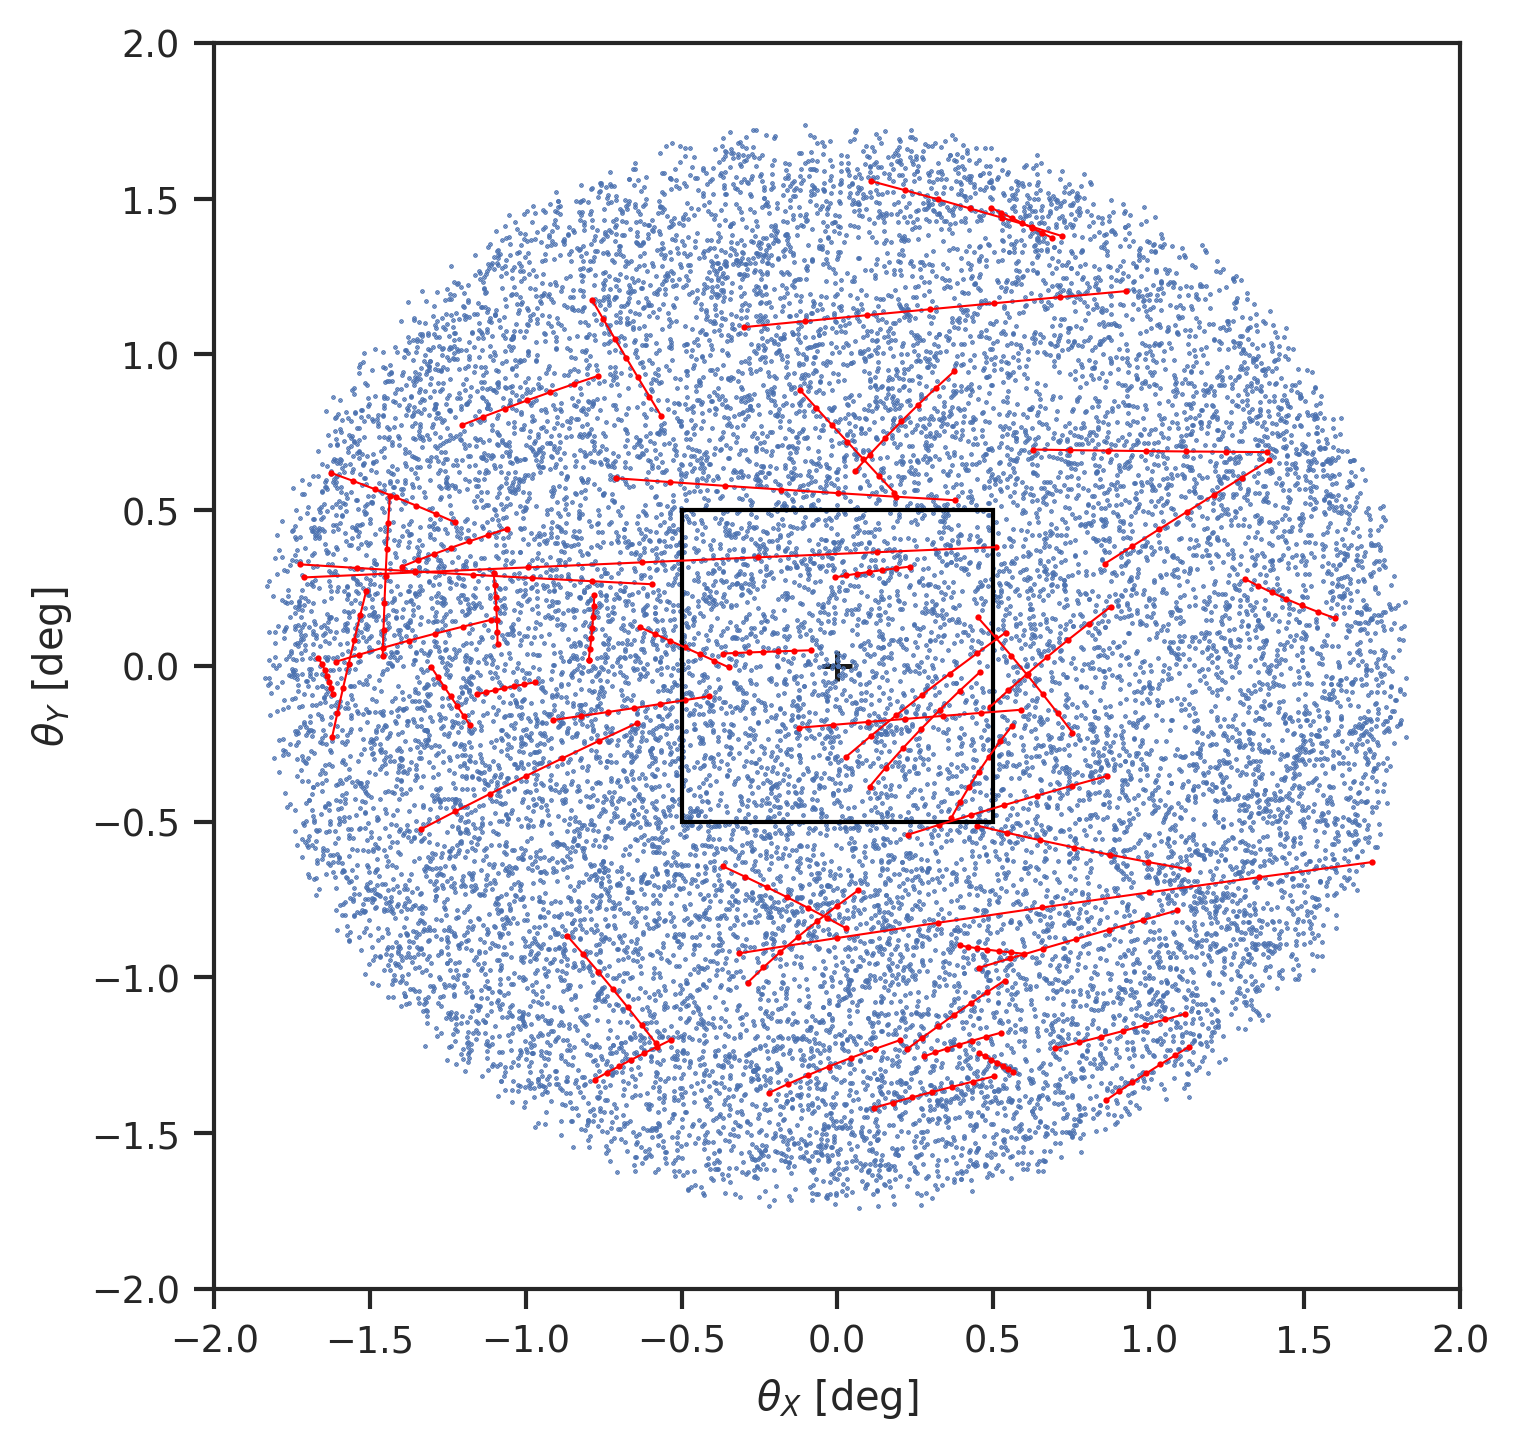

In [27]:
fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))
ax.scatter(0, 0, s=50, c="k", marker="+")
ax.scatter(
    *projected_observations[["theta_x_deg", "theta_y_deg"]].values.T, 
    s=0.1, 
    c="b"
)
for f in findable:
    findable_mask = projected_observations["obj_id"].isin([f])
    ax.plot(
        *projected_observations[findable_mask][["theta_x_deg", "theta_y_deg"]].values.T, 
        lw=0.5, 
        c="red"
    )
ax.scatter(
    *projected_observations[projected_observations["obj_id"].isin(findable)][["theta_x_deg", "theta_y_deg"]].values.T, 
    s=0.5, 
    c="red"
)
ax.set_xlabel(r"$\theta_X$ [$\deg$]")
ax.set_ylabel(r"$\theta_Y$ [$\deg$]")
ax.set_aspect("equal")
ax.add_patch(patches.Rectangle((-0.5, -0.5), 1, 1, fill=False, lw=1, color="black"))
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xticks(np.arange(-2, 2.5, 0.5))
ax.set_yticks(np.arange(-2, 2.5, 0.5))
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "algorithm3.{}".format(FORMAT)),
            bbox_inches='tight')

### Hough Transform

In [28]:
small = (
    (projected_observations["theta_x_deg"] > -0.5)
    & (projected_observations["theta_x_deg"] < 0.5) 
    & (projected_observations["theta_y_deg"] > -0.5) 
    & (projected_observations["theta_y_deg"] < 0.5)
)
chosen = ["97142", "W8761", "S8106", "l7272", "U6429", "T1794", "K15T74X", "Q2049", "K03SW8X", "S0525"]

In [29]:
from thor import clusterVelocity

obs_ids = projected_observations["obs_id"].values
theta_x = projected_observations["theta_x_deg"].values
theta_y = projected_observations["theta_y_deg"].values
mjd = projected_observations["mjd_utc"].values
truth = projected_observations["obj_id"].values

first = np.where(mjd == mjd.min())[0]
theta_x0 = theta_x[first]
theta_y0 = theta_y[first]
mjd0 = mjd[first][0]
dt = mjd - mjd0

vx = 0.008
vy = 0.002
xx = theta_x - vx * dt
yy = theta_y - vy * dt

projected_observations["xx"] = xx
projected_observations["yy"] = yy

clusterVelocity(obs_ids, theta_x, theta_y, dt, vx, vy)

[array(['138681', '462191', '788515', '1117818', '1456786', '1792055',
        '2130337'], dtype=object)]

In [30]:
orbits[orbits["designation"].isin(chosen)]

designation     H     G epoch_pf_TT  meanAnom_deg  argPeri_deg  \
97141        97142  15.0  0.15       K183N     259.31904    322.12438   
262048       Q2049  18.1  0.15       K183N      35.91568    283.42084   
280524       S0525  17.6  0.15       K183N     198.62983    198.85559   
288105       S8106  16.9  0.15       K183N     207.44258    313.18783   
291793       T1794  17.0  0.15       K183N     200.91085    176.81574   
306428       U6429  17.2  0.15       K183N     257.35726    145.78745   
328760       W8761  16.5  0.15       K183N     275.08913    277.65109   
477271       l7272  17.8  0.15       K183N     135.38347    325.73615   
523534     K03SW8X  18.2  0.15       K183N     146.09562    355.54600   
619023     K15T74X  17.6  0.15       K183N     211.24059    323.90297   

        ascNode_deg    i_deg         e  n_deg_p_day  ...  numObs numOppos  \
97141      34.20439  4.90315  0.096050     0.193234  ...   535.0     13.0   
262048    147.05789  2.53321  0.199817     0.277919  ...   107.0      7.0   
280524    135.76358  2.18869  0.202603     0.257484  ...   117.0      9.0   
288105     34.77461  3.96076  0.207056     0.238263  ...   212.0     11.0   
291793    177.69112  7.47670  0.187206     0.236008  ...   211.0      9.0   
306428    174.81330  5.13400  0.262492     0.234420  ...   126.0      8.0   
328760     65.18415  2.96292  0.103041     0.194088  ...   118.0      7.0   
477271     36.22236  5.34436  0.246427     0.273954  ...    71.0      5.0   
523534     37.71170  3.95816  0.209229     0.234860  ...    34.0      5.0   
619023     47.94705  2.43955  0.108848     0.213216  ...    51.0      4.0   

           obsArc  rmsResid_arcsec  coarsePerturbers precisePerturbers  \
97141   1999-2017             0.43               M-v               38h   
262048  2004-2018             0.32               M-v               38h   
280524  2000-2016             0.43               M-v               38h   
288105  2003-2018             0.39               M-v               38h   
291793  2003-2018             0.40               M-v               38h   
306428  1998-2018             0.32               M-v               38h   
328760  2004-2017             0.30               M-v               38h   
477271  2009-2016             0.36               M-v               38h   
523534  2003-2013             0.25               M-v               38h   
619023  2010-2017             0.25               M-v               38h   

        compName flags  readableDesignation lastObsInOrbitSolution  
97141   MPCLINUX  0000   (97142) 1999 VJ141             20170501.0  
262048  MPCLINUX  0000  (262049) 2006 QU182             20180211.0  
280524  MPCLINUX  0000  (280525) 2004 PD108             20161204.0  
288105  MPCLINUX  0000   (288106) 2003 WP46             20180318.0  
291793  MPCLINUX  0000   (291794) 2006 KG64             20180320.0  
306428  MPCLINUX  0000   (306429) 1998 ST45             20180318.0  
328760  MPCLINUX  0000   (328761) 2009 UN94             20170416.0  
477271  MPCLINUX  0000  (477272) 2009 SJ110             20160827.0  
523534    MPCADO  0000           2003 SX328             20130116.0  
619023  MPCLINUX  0000            2015 TX74             20170222.0  

[10 rows x 23 columns]

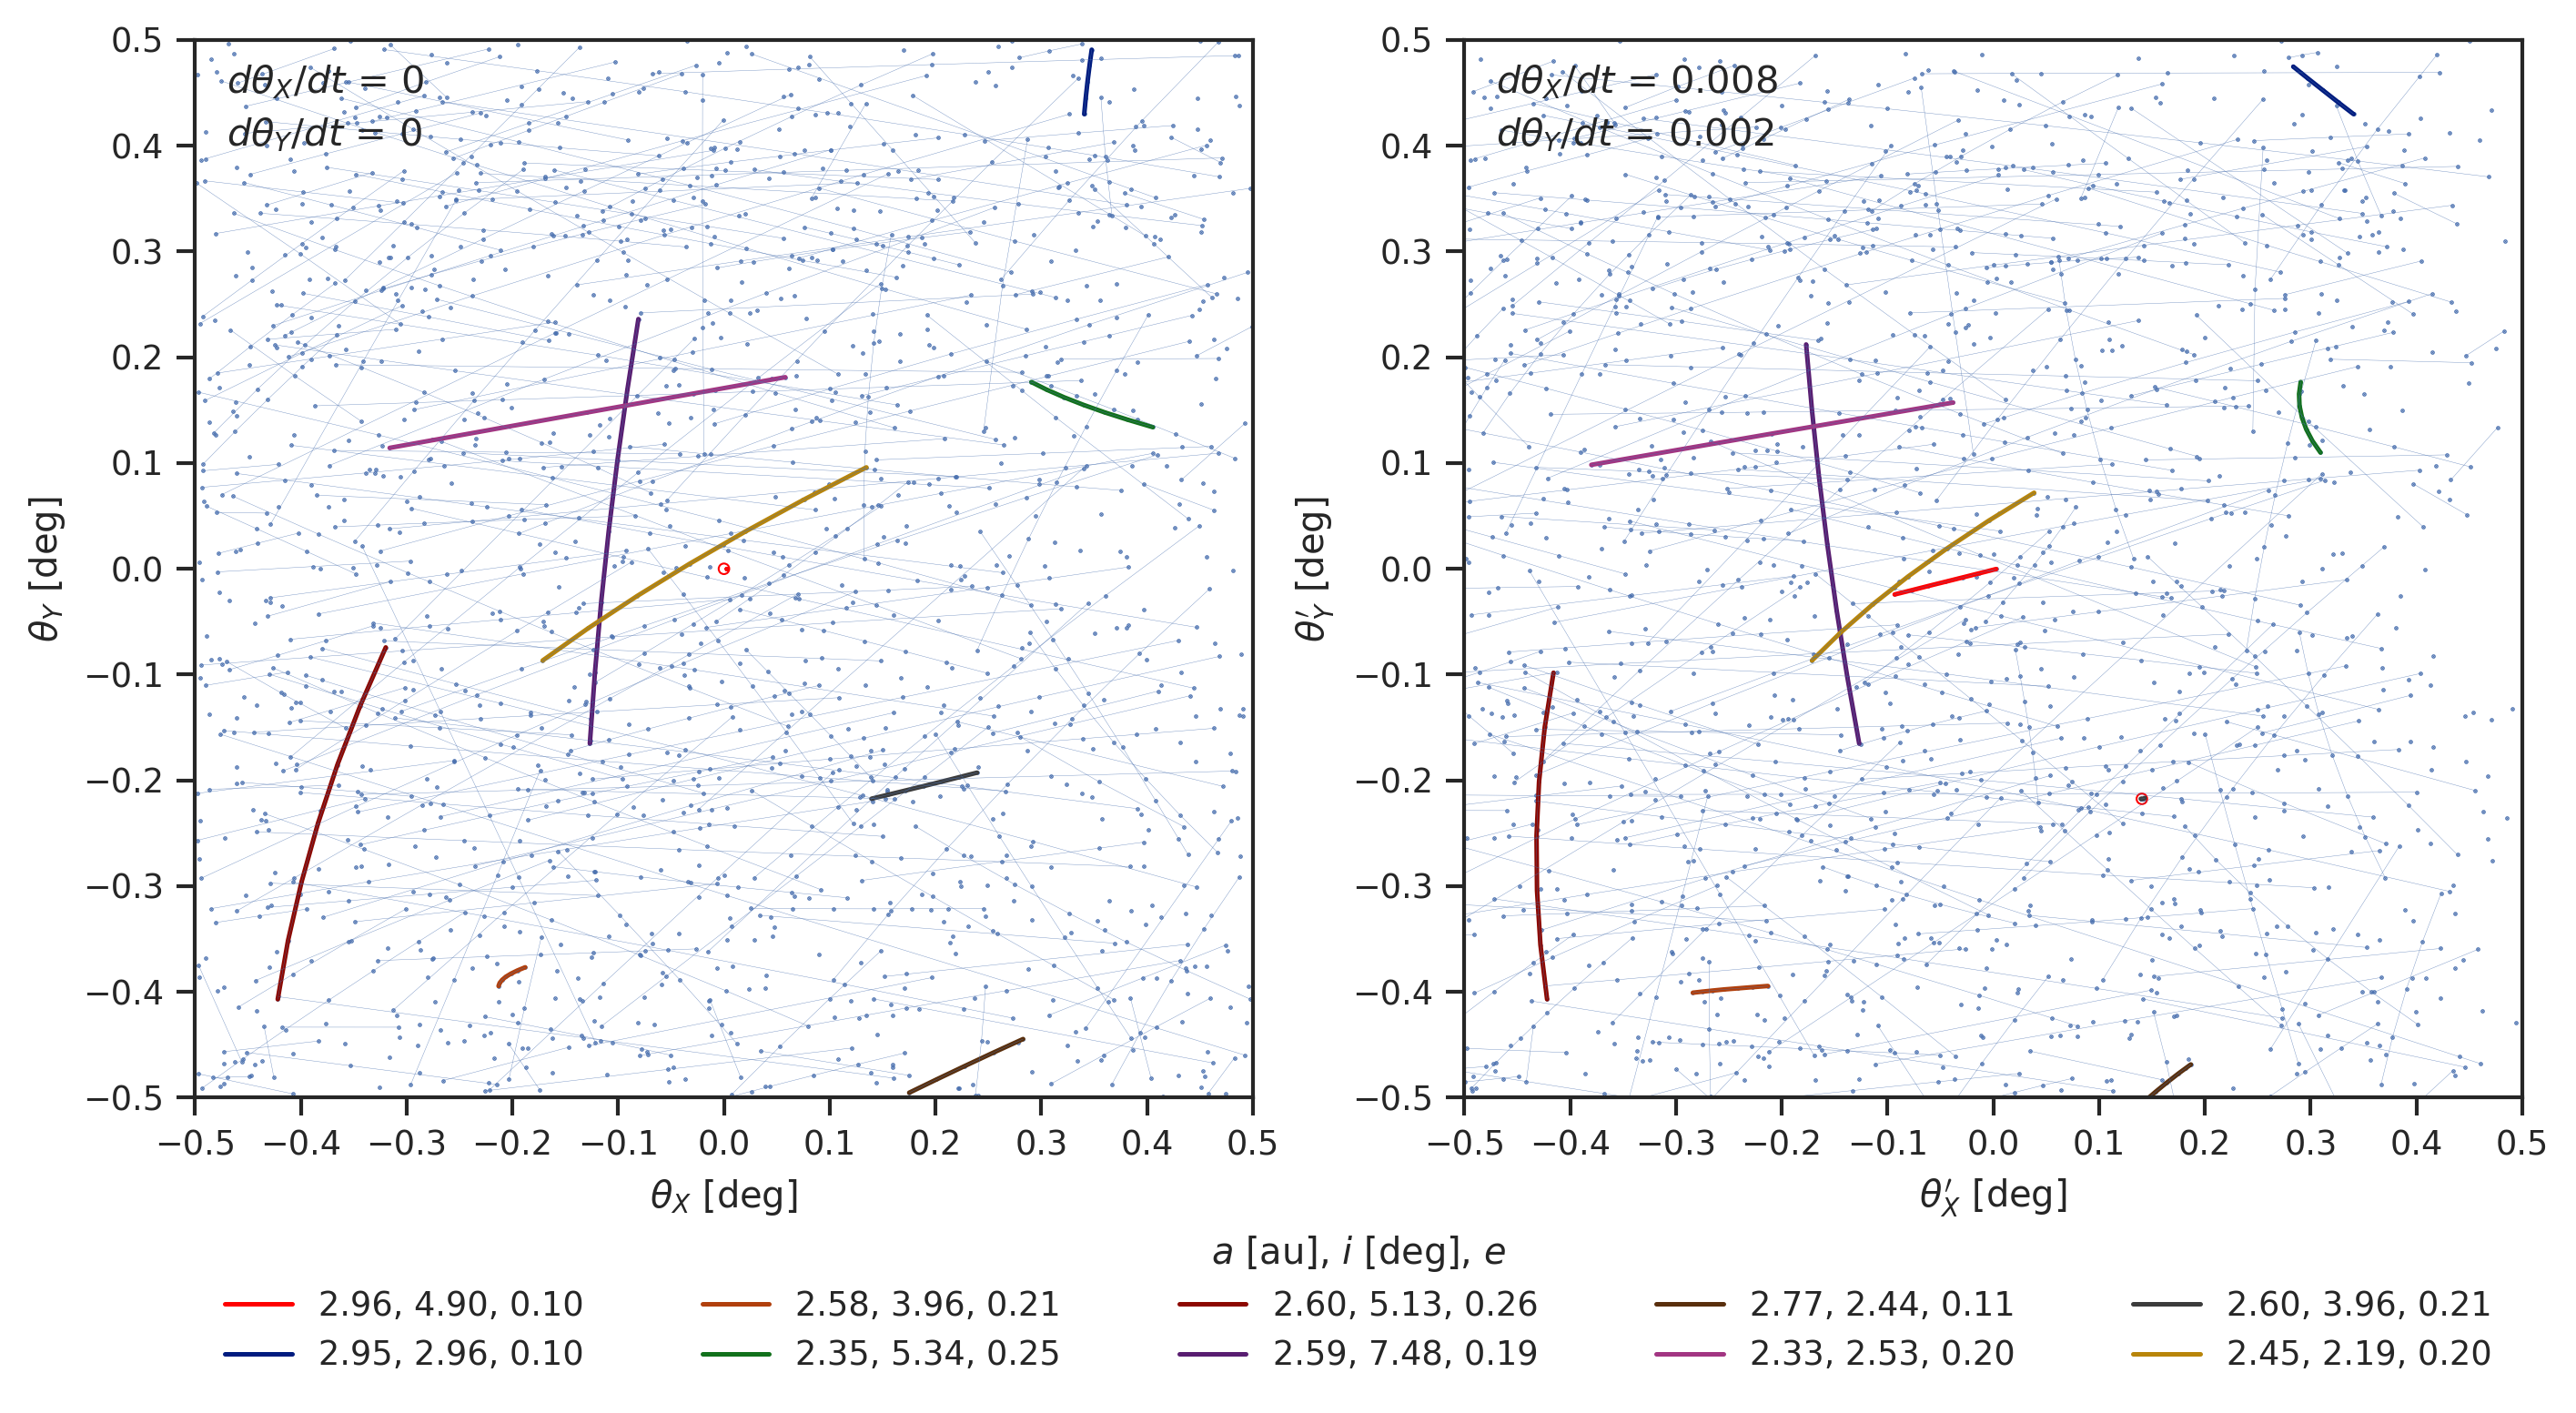

In [32]:
findable = all_truths_projection[all_truths_projection["findable"] == 1]["obj_id"].values

fig, ax = plt.subplots(1, 2, dpi=DPI, figsize=(11, 5.5))

ax[0].scatter(*projected_observations[small][["theta_x_deg", "theta_y_deg"]].values.T, s=0.1, c="b")

for c, designation in zip(['red'] + sns.color_palette("dark").as_hex(), chosen):
    ax[0].plot(
        *projected_observations[small & (projected_observations["obj_id"] == designation)][["theta_x_deg", "theta_y_deg"]].values.T,
        color=c
    )
    
for designation in projected_observations[projected_observations["obj_id"].isin(findable) & small]["obj_id"].unique():
    ax[0].plot(
        *projected_observations[small & (projected_observations["obj_id"] == designation)][["theta_x_deg", "theta_y_deg"]].values.T, 
        lw=0.1, 
        color="b", 
        alpha=0.8
    )

ax[0].set_xlabel(r"$\theta_X$ [$\deg$]")
ax[0].set_ylabel(r"$\theta_Y$ [$\deg$]")
ax[0].set_aspect("equal")
ax[0].add_patch(patches.Circle((0, 0), 0.005, fill=False, lw=0.5, color="red"))
ax[0].text(-0.47, 0.45, r"$d\theta_X/dt$ = 0")
ax[0].text(-0.47, 0.4, r"$d\theta_Y/dt$ = 0")


ax[1].scatter(*projected_observations[small][["xx", "yy"]].values.T, s=0.1, c="b")

for c, designation in zip(['red'] + sns.color_palette("dark").as_hex(), chosen):
    ax[1].plot(
        *projected_observations[small & (projected_observations["obj_id"] == designation)][["xx", "yy"]].values.T,
        color=c, 
        label="{:.2f}, {:.2f}, {:.2f}".format(*orbits[orbits["designation"] == designation][["a_au", "i_deg", "e"]].values[0]))
    
for designation in projected_observations[projected_observations["obj_id"].isin(findable) & small]["obj_id"].unique():
    ax[1].plot(
        *projected_observations[small & (projected_observations["obj_id"] == designation)][["xx", "yy"]].values.T, 
        lw=0.1, 
        color="b", 
        alpha=0.8
    )
    
ax[1].set_xlabel(r"$\theta_X'$ [$\deg$]")
ax[1].set_ylabel(r"$\theta_Y'$ [$\deg$]")
ax[1].set_aspect("equal")
ax[1].add_patch(patches.Circle((0.140453, -0.217489), 0.005, fill=False, lw=0.5, color="red"))

ax[1].text(-0.47, 0.45, r"$d\theta_X/dt$ = {}".format(vx))
ax[1].text(-0.47, 0.4, r"$d\theta_Y/dt$ = {}".format(vy))
ax[1].legend(
    bbox_to_anchor=(-1.2, -0.4, 2.2, 0.3), 
    title="$a$ [au], $i$ [$\deg$], $e$", 
    ncol=5, 
    mode="expand",
    frameon=False
)

for a in ax:
    a.set_xlim(-0.5, 0.5)
    a.set_ylim(-0.5, 0.5)
    a.set_xticks(np.arange(-0.5, 0.6, 0.1))
    a.set_yticks(np.arange(-0.5, 0.6, 0.1))
    
if SAVE_FIGS is True:
    fig.savefig(
        os.path.join(SAVE_DIR, "algorithm4.{}".format(FORMAT)),
        bbox_inches='tight'
    )


### Co-rotating Frame Velocities

In [33]:
average_object = findAverageOrbits(observations, orbits[orbits["designation"] == "18043"])

In [34]:
average_object

orbit_id       exp_mjd  HEclObj_X_au  HEclObj_Y_au  HEclObj_Z_au  \
0         1  59740.218056     -3.123217     -0.291872      0.158942   
1         1  59742.218056     -3.121086     -0.310375      0.159281   
2         1  59744.218056     -3.118837     -0.328867      0.159615   
3         1  59746.218056     -3.116468     -0.347345      0.159942   
4         1  59748.218056     -3.113980     -0.365810      0.160263   
5         1  59750.218056     -3.111373     -0.384262      0.160578   
6         1  59752.218056     -3.108647     -0.402698      0.160887   

   HEclObj_dX/dt_au_p_day  HEclObj_dY/dt_au_p_day  HEclObj_dZ/dt_au_p_day  \
0                0.001035               -0.009255                0.000171   
1                0.001095               -0.009249                0.000168   
2                0.001155               -0.009243                0.000165   
3                0.001214               -0.009237                0.000162   
4                0.001274               -0.009230                0.000159   
5                0.001333               -0.009223                0.000156   
6                0.001393               -0.009215                0.000153   

       RA_deg   Dec_deg      r_au      a_au    i_deg         e designation  
0  168.738396  8.117743  3.140849  2.910515  3.10391  0.080989       18043  
1  169.068597  7.956218  3.140523  2.910515  3.10391  0.080989       18043  
2  169.411728  7.789360  3.140187  2.910515  3.10391  0.080989       18043  
3  169.767381  7.617335  3.139841  2.910515  3.10391  0.080989       18043  
4  170.135191  7.440286  3.139487  2.910515  3.10391  0.080989       18043  
5  170.514827  7.258342  3.139122  2.910515  3.10391  0.080989       18043  
6  170.905972  7.071623  3.138748  2.910515  3.10391  0.080989       18043

In [35]:
test_orbit = Orbits(
    average_object[['HEclObj_X_au', 'HEclObj_Y_au', 'HEclObj_Z_au', 'HEclObj_dX/dt_au_p_day', 'HEclObj_dY/dt_au_p_day', 'HEclObj_dZ/dt_au_p_day']].values[:1],
    Time(average_object["exp_mjd"].values[:1], scale="utc", format="mjd"),
    ids=average_object["designation"].values[:1]
)

projected_observations_500 = rangeAndShift(
    preprocessed_observations, 
    test_orbit, 
    cell_area=500,
    backend="PYOORB",
    backend_kwargs={},
    threads=60
)

# Add object IDs to the dataframe
projected_observations_500 = projected_observations_500.merge(preprocessed_associations, on="obs_id")
projected_observations_500 = projected_observations_500[~projected_observations_500["obj_id"].str.contains("^u[0-9]{8}")]
projected_observations_500 = projected_observations_500.merge(observations[["obsId", "r_au"]], left_on="obs_id", right_on="obsId")
projected_observations_500.reset_index(
    inplace=True,
    drop=True
)

11:15:47.516 [INFO] thor - Running range and shift...
11:15:47.518 [INFO] thor - Assuming r = [-3.12321668 -0.29187232  0.15894187] au
11:15:47.518 [INFO] thor - Assuming v = [ 0.00103538 -0.00925509  0.00017125] au per day
11:15:55.066 [INFO] thor - Found 231652 observations.
11:15:55.067 [INFO] thor - Range and shift completed in 7.550 seconds.


In [36]:
all_truths_projection500, findable_observations500, summary_projection500 = analyzeObservations(
    projected_observations_500,
    metric="min_obs",
    min_obs=5,
    column_mapping=column_mapping
)

In [37]:
def calculateLinearVelocity(x):
    dt = (x.mjd_utc - x.mjd_utc.iloc[0])
    if len(dt) > 1:
        vx = (x.theta_x_deg - x.theta_x_deg.iloc[0]) / dt
        vy = (x.theta_y_deg - x.theta_y_deg.iloc[0]) / dt
        vx_median = np.nanmedian(vx.values)
        vy_median = np.nanmedian(vy.values)
        vx_sigma = np.nanstd(vx.values)
        vy_sigma = np.nanstd(vy.values)
        
    else:
        vx_median = np.NaN
        vy_median = np.NaN
        vx_sigma = np.NaN
        vy_sigma = np.NaN
        
    result = {
        "vtheta_x_median" : vx_median,
        "vtheta_y_median" : vy_median,
        "vtheta_x_sigma" : vx_sigma,
        "vtheta_y_sigma" : vy_sigma,
    }
    return pd.Series(result)

linear_velocities = projected_observations_500.groupby(by=["obj_id"]).apply(calculateLinearVelocity)
linear_velocities.reset_index(inplace=True)
all_truths_projection500 = all_truths_projection500.merge(linear_velocities, on="obj_id")
heliocentric_distances = projected_observations_500.groupby(by=["obj_id"])["r_au"].apply(np.median).to_frame(name="r_au_median")
heliocentric_distances.reset_index(inplace=True)
all_truths_projection500 = all_truths_projection500.merge(heliocentric_distances, on="obj_id")

In [38]:
all_truths_projection500.head()

obj_id  num_obs  findable  vtheta_x_median  vtheta_y_median  vtheta_x_sigma  \
0  00828        8         1         0.001649        -0.006567        0.000107   
1  06215        8         1         0.087824         0.004329        0.001160   
2  10510        8         1         0.168601         0.025427        0.004084   
3  13069        8         1         0.085912        -0.029539        0.000644   
4  17000        8         1         0.170859        -0.035795        0.003774   

   vtheta_y_sigma  r_au_median  
0        0.000043     3.201093  
1        0.000014     2.542260  
2        0.000193     2.027222  
3        0.000280     2.525323  
4        0.000256     2.000734

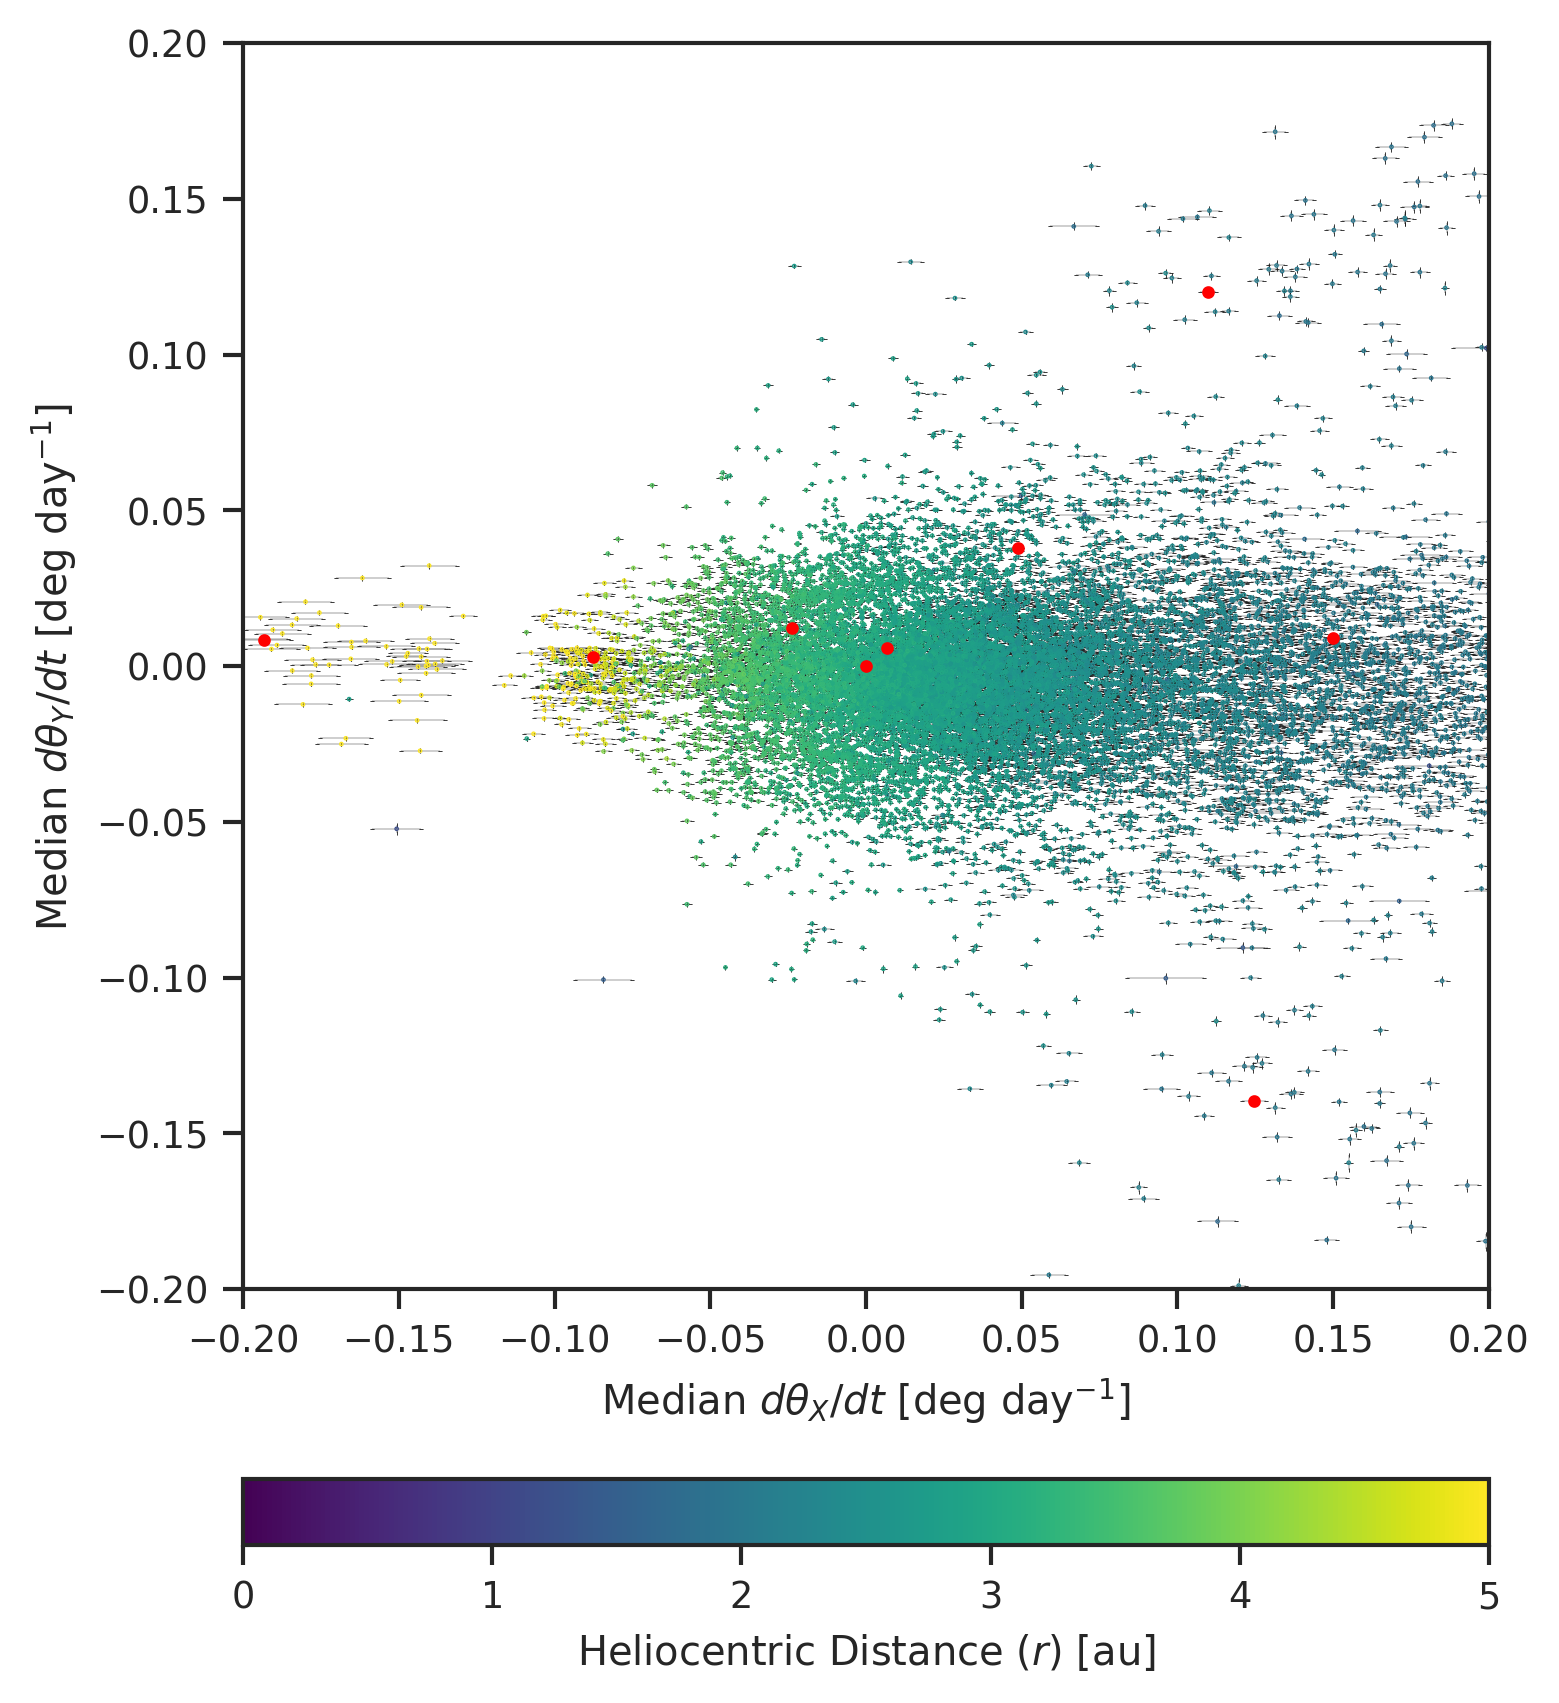

In [39]:
findable_mask = (all_truths_projection500["findable"] == 1)

fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))
ax.errorbar(
    all_truths_projection500[findable_mask]["vtheta_x_median"].values,
    all_truths_projection500[findable_mask]["vtheta_y_median"].values,
    xerr=all_truths_projection500[findable_mask]["vtheta_x_sigma"].values,
    yerr=all_truths_projection500[findable_mask]["vtheta_y_sigma"].values,
    fmt="o",
    ms=0.01,
    capsize=0.1,
    elinewidth=0.1,
    c="k", 
    zorder=-1
)
cm = ax.scatter(
    all_truths_projection500[findable_mask]["vtheta_x_median"].values,
    all_truths_projection500[findable_mask]["vtheta_y_median"].values,
    s=0.1,
    c=all_truths_projection500[(all_truths_projection500["findable"] == 1)]["r_au_median"].values,
    vmin=0,
    vmax=5.0,
    cmap="viridis"
)
ax.set_aspect("equal")
ax.scatter(
    all_truths_projection500[(all_truths_projection500["obj_id"].isin(test_orbits["orbit_id"].values))]["vtheta_x_median"].values, 
    all_truths_projection500[(all_truths_projection500["obj_id"].isin(test_orbits["orbit_id"].values))]["vtheta_y_median"].values,
    s=5,
    c="red"
)

cbar_ax = fig.add_axes([0.135, -0.03, 0.755, 0.04])
fig.colorbar(
    cm,  
    cax=cbar_ax,  
    label=r"Heliocentric Distance ($r$) [au]", 
    orientation="horizontal"
)

# Add labels and text
cbar_ax.set_label("r [au]")
ax.set_xlabel(r"Median $d\theta_X / dt$ [$\deg$ $\mathrm{day}^{-1}$]")
ax.set_ylabel(r"Median $d\theta_Y / dt$ [$\deg$ $\mathrm{day}^{-1}$]")
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_aspect("equal")
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "orbit_frame_velocity_500.{}".format(FORMAT)),
            bbox_inches='tight')

### Completeness

In [40]:
def plotCompleteness(
        all_truths, 
        orbits, 
        test_orbits=None, 
        test_orbit_scatter_kwargs={"s": 2, "c": "red"}
    ):
    
    findable = all_truths[all_truths["findable"] >= 1]["obj_id"].values
    found = all_truths[all_truths["found"] >= 1]["obj_id"].values
    missed = all_truths[(all_truths["found"] == 0) & (all_truths["findable"] >= 1)]["obj_id"].values

    BINS = 50
    RANGE_AI = [[0.5, 5.5], [0, 50]]
    RANGE_AE = [RANGE_AI[0], [0, 1]]
    LEVELS = [10, 100, 1000]

    # Calculate 2D binned statistics:
    # X_ai: orbital distribution in a and i
    # N_ai : number of objects discoverable in same bins as X_ai
    X_ai = binned_statistic_2d(
        orbits[orbits["designation"].isin(found)]["a_au"].values,
        orbits[orbits["designation"].isin(found)]["i_deg"].values,
        orbits[orbits["designation"].isin(found)]["e"].values,    
        statistic="count",
        range=RANGE_AI,
        bins=BINS
    )

    N_ai = binned_statistic_2d(
        orbits[orbits["designation"].isin(findable)]["a_au"].values,
        orbits[orbits["designation"].isin(findable)]["i_deg"].values,
        orbits[orbits["designation"].isin(findable)]["e"].values,    
        statistic="count",
        range=RANGE_AI,
        bins=BINS
    )
    
    stat_ai = X_ai.statistic.T / N_ai.statistic.T * 100.0
    counts_ai = N_ai.statistic.T
    stat_ai=np.ma.masked_where(stat_ai==np.NaN, stat_ai)
    
    # Calculate 2D binned statistics:
    # X_ae: orbital distribution in a and e
    # N_ae : number of objects discoverable in same bins as X_ai
    X_ae = binned_statistic_2d(
        orbits[orbits["designation"].isin(found)]["a_au"].values,
        orbits[orbits["designation"].isin(found)]["e"].values,
        orbits[orbits["designation"].isin(found)]["i_deg"].values,    
        statistic="count",
        range=RANGE_AE,
        bins=BINS
    )

    N_ae = binned_statistic_2d(
        orbits[orbits["designation"].isin(findable)]["a_au"].values,
        orbits[orbits["designation"].isin(findable)]["e"].values,
        orbits[orbits["designation"].isin(findable)]["i_deg"].values,    
        statistic="count",
        range=RANGE_AE,
        bins=BINS
    )

    stat_ae = X_ae.statistic.T / N_ae.statistic.T * 100.0
    counts_ae = N_ae.statistic.T
    stat_ae=np.ma.masked_where(stat_ae==np.NaN, stat_ae)
    
    # Make the figure
    fig, ax = plt.subplots(2, 1, dpi=DPI, figsize=(5.5, 9))
    fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.15,  
        # the right side of the subplots of the figure
        right=1.0,
        # the bottom of the subplots of the figure
        bottom=0.2,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.01,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.2)   
                       
    
    # Set NaN values in stat to be white 
    cmap = copy.copy(matplotlib.cm.get_cmap("viridis"))
    cmap.set_bad('w', np.NaN)
    
    # Plot a-i completeness
    cm1 = ax[0].imshow(
        stat_ai, 
        origin="lower", 
        cmap=cmap,
        interpolation='none',
        aspect="auto",
        extent=[X_ai.x_edge[0], X_ai.x_edge[-1], X_ai.y_edge[0], X_ai.y_edge[-1]]
    )

    # Add contours
    cs1 = ax[0].contour(
        counts_ai, 
        LEVELS, 
        origin="lower", 
        extent=[N_ai.x_edge[0], N_ai.x_edge[-1], N_ai.y_edge[0], N_ai.y_edge[-1]],
        colors="red",
        linewidths=1
    )
    plt.clabel(cs1, inline=1, fontsize=4, fmt="%1.0f")

    # Add labels
    ax[0].set_ylabel("Inclination ($i$) [$\deg$]")
    ax[0].set_xlabel("Semi-Major Axis ($a$) [au]")
    ax[0].set_xlim(*RANGE_AI[0])
    ax[0].set_ylim(*RANGE_AI[1])
    ax[0].set_xticks(np.arange(0.5, 6.0, 0.5))
    ax[0].set_yticks(np.arange(0.0, 55, 5))
    
    # Plot a-e completeness
    cm2 = ax[1].imshow(
        stat_ae, 
        origin="lower", 
        cmap=cmap,
        interpolation='none',
        aspect="auto",
        #norm=colors.LogNorm(),
        extent=[X_ae.x_edge[0], X_ae.x_edge[-1], X_ae.y_edge[0], X_ae.y_edge[-1]]
    )
    
    # Plot test orbits 
    if type(test_orbits) == pd.DataFrame:
        
        ax[0].scatter(
            *test_orbits[["a_au", "i_deg"]].values.T, 
            label="Test Orbits",
            zorder=10,
            **test_orbit_scatter_kwargs
        )

        ax[1].scatter(
            *test_orbits[["a_au", "e"]].values.T, 
            label="Test Orbits",
            zorder=10,
            **test_orbit_scatter_kwargs
        )

    # Add contours
    cs2 = ax[1].contour(
        counts_ae, 
        LEVELS, 
        origin="lower", 
        extent=[N_ae.x_edge[0], N_ae.x_edge[-1], N_ae.y_edge[0], N_ae.y_edge[-1]],
        colors="red",
        linewidths=1
    )
    plt.clabel(cs2, inline=1, fontsize=4, fmt="%1.0f")

    # Add labels
    ax[1].set_ylabel("Eccentricity ($e$)")
    ax[1].set_xlabel("Semi-Major Axis ($a$) [au]")
    ax[1].set_xlim(*RANGE_AE[0])
    ax[1].set_ylim(*RANGE_AE[1])
    ax[1].set_xticks(np.arange(0.5, 6.0, 0.5))
    ax[1].set_yticks(np.arange(0.0, 1.1, 0.1))
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.65, 0.02])
    fig.colorbar(cm2, 
                 cax=cbar_ax, 
                 label="Completeness [%]", 
                 format="%1i", 
                 orientation="horizontal")
     
    return fig, ax 

In [46]:
orbits

designation      H     G epoch_pf_TT  meanAnom_deg  argPeri_deg  \
32           00033   8.55  0.33       K183N     261.32809    338.15623   
38           00039   6.00  0.15       K183N     216.69404    208.48159   
141          00142  10.27  0.15       K183N     298.02758    292.13151   
149          00150   8.23  0.15       K183N     251.47552    152.80273   
170          00171   8.31  0.15       K183N     118.53497     56.22102   
...            ...    ...   ...         ...           ...          ...   
758351     K18F09P  18.10  0.15       K1833     266.14541    277.92939   
758355     K18F10B  18.20  0.15       K1833     269.87354    163.95690   
758360     K18F10W  17.30  0.15       K1833     223.11373    199.93964   
758394     K18F18B  18.80  0.15       K183N       8.77896    119.34931   
758506     T3S3411  17.50  0.15       J77AO     336.76277     31.99541   

        ascNode_deg     i_deg         e  n_deg_p_day  ...  numObs numOppos  \
32          8.59509   1.85668  0.332364     0.202070  ...  2391.0     64.0   
38        157.07162  10.36984  0.112095     0.213626  ...  5390.0     87.0   
141       291.24786   2.23846  0.134862     0.262104  ...  2411.0     48.0   
149       206.15087   2.20122  0.123430     0.190922  ...  2443.0     59.0   
170       100.47866   2.54679  0.132461     0.178088  ...  2317.0     62.0   
...             ...       ...       ...          ...  ...     ...      ...   
758351     11.78184   5.61884  0.183469     0.240462  ...    11.0      1.0   
758355    129.51677   3.60233  0.251227     0.247192  ...    11.0      1.0   
758360    128.11657   4.47142  0.226620     0.245393  ...    14.0      1.0   
758394     52.69858   4.86867  0.185574     0.235923  ...    19.0      1.0   
758506     23.87322   4.79089  0.164683     0.252066  ...     8.0      1.0   

           obsArc  rmsResid_arcsec  coarsePerturbers precisePerturbers  \
32      1856-2018             0.50               M-v               38h   
38      1856-2018             0.54               M-v               38h   
141     1898-2018             0.46               M-v               38h   
149     1899-2018             0.47               M-v               38h   
170     1894-2018             0.45               M-v               38h   
...           ...              ...               ...               ...   
758351     2 days             0.14              None              None   
758355     2 days             0.14              None              None   
758360     9 days             0.17              None              None   
758394    34 days             0.21              None              None   
758506    10 days              NaN              None              None   

        compName flags readableDesignation lastObsInOrbitSolution  
32      MPCLINUX  0000     (33) Polyhymnia             20180327.0  
38      MPCLINUX  0000       (39) Laetitia             20180319.0  
141     MPCLINUX  0000        (142) Polana             20180329.0  
149     MPCLINUX  0000          (150) Nuwa             20180328.0  
170     MPCLINUX  0000       (171) Ophelia             20180316.0  
...          ...   ...                 ...                    ...  
758351      MPCW  0000            2018 FP9             20180319.0  
758355      MPCW  0000           2018 FB10             20180319.0  
758360      MPCW  0000           2018 FW10             20180319.0  
758394    MPCMEL  0000           2018 FB18             20180413.0  
758506  Bardwell  2000            3411 T-3             19771017.0  

[24481 rows x 23 columns]

In [48]:
test_orbits.columns

Index(['orbit_id', 'epoch', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'obsId',
       'visitId', 'fieldId', 'fieldRA_deg', 'fieldDec_deg', 'exp_mjd', 'night',
       'designation', 'code', 'mjd_utc', 'Delta_au', 'RA_deg', 'Dec_deg',
       'dDelta/dt_au_p_day', 'dRA/dt_deg_p_day', 'dDec/dt_deg_p_day', 'VMag',
       'Alt_deg', 'PhaseAngle_deg', 'LunarElon_deg', 'LunarAlt_deg',
       'LunarPhase', 'SolarElon_deg', 'SolarAlt_deg', 'r_au', 'HLon_deg',
       'HLat_deg', 'TLon_deg', 'TLat_deg', 'TOCLon_deg', 'TOCLat_deg',
       'HOCLon_deg', 'HOCLat_deg', 'TOppLon_deg', 'TOppLat_deg',
       'HEclObj_X_au', 'HEclObj_Y_au', 'HEclObj_Z_au',
       'HEclObj_dX/dt_au_p_day', 'HEclObj_dY/dt_au_p_day',
       'HEclObj_dZ/dt_au_p_day', 'HEclObsy_X_au', 'HEclObsy_Y_au',
       'HEclObsy_Z_au', 'EccAnom', 'TrueAnom', 'PosAngle_deg'],
      dtype='object')

<ipython-input-40-327146b45013>:38: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-40-327146b45013>:63: RuntimeWarning:

invalid value encountered in true_divide



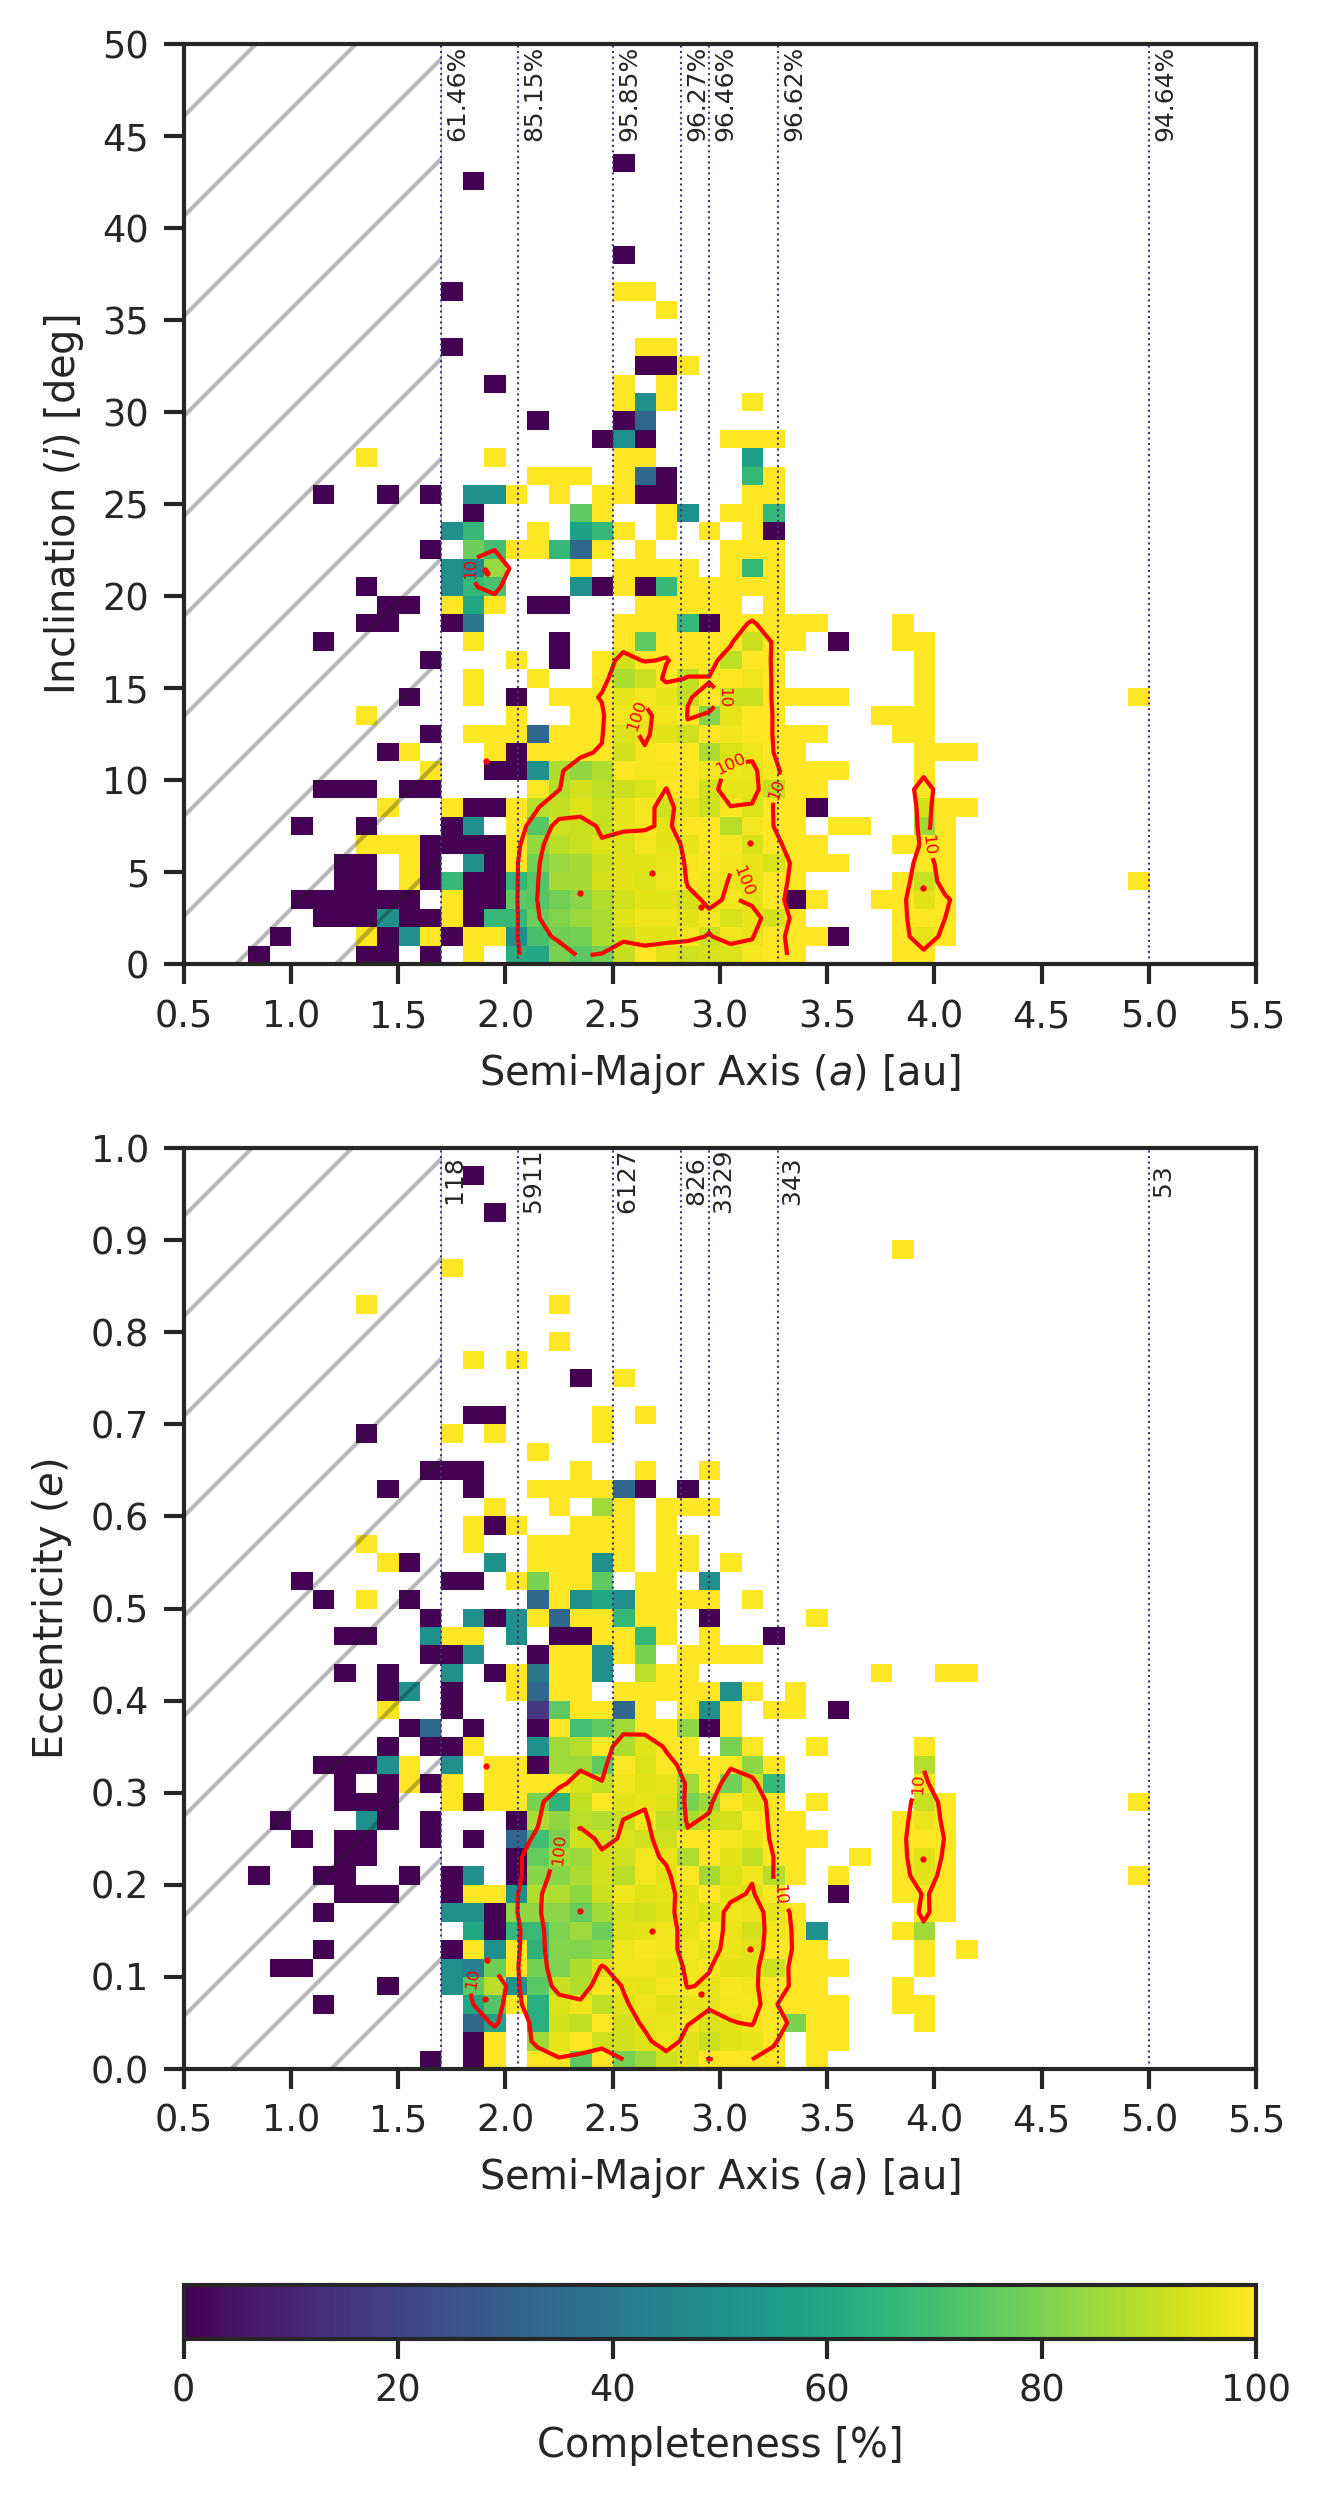

In [49]:
fig, ax = plotCompleteness(
    all_truths_recovered, 
    orbits, 
    test_orbits=orbits[orbits["designation"].isin(test_orbits["designation"].values)],
    test_orbit_scatter_kwargs={
        "s": 0.5, 
        "c": "red"
    },
)
ax[0].vlines([1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0], 0, 50, lw=0.5, linestyle=":")
ax[1].vlines([1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0], 0, 50, lw=0.5, linestyle=":")

sma_bins = [1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0, 50]
classes = {}
for i, (bin_start, bin_end) in enumerate(zip(sma_bins[:-1], sma_bins[1:])):
    mask = (summary_recovered["class"] == "{}<=a<{}".format(bin_start, bin_end))
    completeness_bin = summary_recovered[mask]["completeness"].values[0]
    found_bin = summary_recovered[mask]["found"].values[0]
    ax[0].text(
        bin_start + 0.02, 
        45, 
        f"{completeness_bin:.2f}%", 
        fontsize=6, 
        rotation='vertical'
    )
    
    ax[1].text(
        bin_start + 0.02, 
        0.9, 
        f"{found_bin}".rjust(8, " "), 
        fontsize=6, 
        rotation='vertical'
    )
ax[0].fill_between([0,1.7], [50,50], 
    facecolor="none", 
    hatch="/", 
    edgecolor="k", 
    linewidth=0.2,
    alpha=0.3
)
ax[1].fill_between([0,1.7], [1,1], 
    facecolor="none", 
    hatch="/", 
    edgecolor="k", 
    linewidth=0.2,
    alpha=0.3
)

if SAVE_FIGS is True:
    fig.savefig(
        os.path.join(SAVE_DIR, "simulations_a_ie_completeness.{}".format(FORMAT)),
        bbox_inches='tight'
    )